# Multiview Embedding

## Co-Regularized Multiview Spectral Clustering
When the dataset has more than one representation, each of them is named view. In the context of spectral clustering, 
co-regularization techniques attempt to encourage the similarity of the examples in the new representation generated 
from the eigenvectors of each view.

Let $X^{(v)}=\{ x_1^{(v)}, x_2^{(v)},...,x_m^{(v)}\}$ be the samples for view $v$ and $L^{(v)}$ the Laplacian matrix 
created from $X$ for view $v$. $U^{(v)}$ is defined as the matrix formed by the first $k$ eigenvectors  of the Laplacian Matrix. A criterion was proposed in \cite{Kumar11} that measures the disagreement between two 
representations: 


  $$
  D(U^{(v)}, U^{(w)}) = \norm{ \frac{K_{U^{(v)}}} {\norm{K_{U^{(v)}}}_F} -\frac{K_{U^{(w)}}}
  {\norm{K_{U^{(w)}}}_F}}_F^2
  $$

 where $K_{U^{(v)}}$ is the similarity matrix generated from the patterns of the new representation $U^{(v)}$ 
and $\vert \vert  \cdot \vert \vert_F $ is the Frobenius norm. If the inner product among the vectors is used as similarity measure, 
$K_{U^{(v)}} = U^{(v)}{U^{(v)}}^T$ is obtained. Ignoring the constant additive and scaling terms, the previous equation 
can be formulated as follows: 


  $$
   D(U^{(v)}, U^{(w)}) = -\Tr{  U^{(v)}{U^{(v)}}^T  U^{(w)}{U^{(w)}}^T } 
  $$

The objective is to minimize the disagreement  among the representations obtained from each view. Therefore, if we have 
$m$ views, we obtain the following optimization problem that combines the invididual spectral clustering objectives and 
the objective that determines the disagreement among the representations: 

$$
\begin{equation*}
\begin{aligned}
& \underset{\begin{matrix} U^{(i)} \in R^{n \times k}, \\ 1 \leq i \leq m 
\end{matrix}}{\text{max}}
& & \sum\limits_{v=1}^m \Tr{{U^{(v)}}^T L^{(v)}  U^{(v)}} + \lambda \sum\limits_{ {\begin{matrix} 1 \leq v, w \leq m\\ v\neq w \end{matrix} } } 
\Tr{{U^{(w)}}^T L^{(w)} U^{(w)}} \\
& \text{subject to}
& & {U^{(v)}}^T U^{(v)} =  I \hspace{10pt} \forall 1 \leq v \leq m
\end{aligned}
\end{equation*}
$$

The $\lambda$ parameter balances the spectral clustering objective and the disagreement among the 
representations. The problem of 
joint optimization can be solved using alternating maximization. Given $U^{(w)}, 1 \leq w \leq m $, the following 
problem of optimization is obtained for $U^{(v)}, v\neq w$:
$$
\begin{equation*}
\begin{aligned}
& \underset{U^{(v)} \in R^{n \times k}}{\text{max}}
& & \Tr{ {U^{(v)}}^T \left(  LM^{(v)} \right) U^{(v)}} \\
& \text{subject to}
& & {U^{(v)}}^T U^{(v)} =   I
\end{aligned}
\end{equation*}
$$

resulting in a traditional clustering algorithm with the Laplacian matrix modified  
$$
LM^{(v)} = L^{(v)} + \lambda \sum\limits_{{\begin{matrix} 1 \leq w \leq m \\ v \neq w \end{matrix}}} U^{(w)}{U^{(w)}}^T 
$$


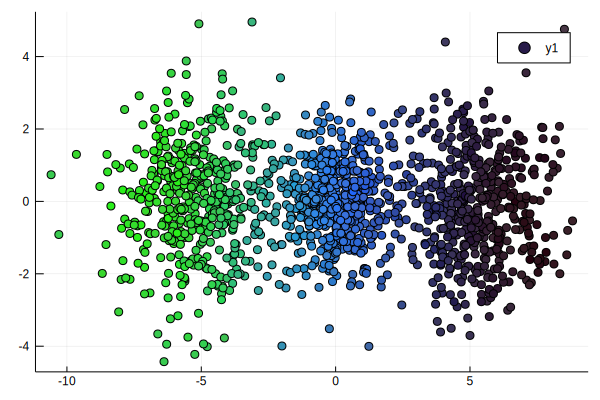

In [11]:
using SpectralClustering, Distances, Plots, Images
function three_gaussians(N::Integer = 250; )
    d1 = (randn(2, N) * 1.5) .+ [5, 0]
    d2 = (randn(2, N) * 1) .+ [0, 0]
    d3 = (randn(2, N) * 1.5) .+ [-5, 0]
    labels = round.(Integer, vcat(zeros(N), ones(N), ones(N)* 2))
    return (hcat(d1, d2, d3), labels)
end

function weight_1(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(), m, v) / 15)
end
function weight_2(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(), m, v) / 45)
end
(data, labels) = three_gaussians(500)
knnconfig = KNNNeighborhood(data, 7)
graph_1 = create(knnconfig, weight_1, data);
graph_2 = create(knnconfig, weight_2, data);
coreg = CoRegularizedMultiView([View(3, 0.001),
                                View(3, 0.001)])
emb = embedding(coreg, [graph_1, graph_2])

scatter(data[1, :], data[2, :], color=imadjustintensity(colorview(RGB, emb')))

# References

In [4]:
using DocUtils
display("text/html",bibliography(["kumar2011co"]))


<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN">
 
 
 
 Bibliography 
 
 
 
 KRD011 
 Abhishek Kumar, Piyush Rai, and Hal Daume.
Co-regularized multi-view spectral clustering.
In Advances in neural information processing systems . 2011.